<a href="https://colab.research.google.com/github/sumitra288/ML-LAB-A1-G3-/blob/main/Experiment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

sns.set()
np.set_printoptions(precision=3, suppress=True)


In [ ]:

ROWS = 3
COLS = 4


WALL = (1, 1)
GOAL = (0, 3)
PIT = (1, 3)


DEFAULT_LIVING_PENALTY = -0.04
GAMMA = 0.99


ACTIONS = ['up', 'right', 'down', 'left']
ACTION_VECTORS = {
    'up': (-1, 0),
    'right': (0, 1),
    'down': (1, 0),
    'left': (0, -1)
}


LEFT_OF = {'up': 'left', 'left': 'down', 'down': 'right', 'right': 'up'}
RIGHT_OF = {a: b for b, a in LEFT_OF.items()}

def in_grid(s):
    r, c = s
    return 0 <= r < ROWS and 0 <= c < COLS

def is_terminal(s):
    return s == GOAL or s == PIT


STATES = [(r, c) for r in range(ROWS) for c in range(COLS) if (r, c) != WALL]


def make_rewards(living_penalty=DEFAULT_LIVING_PENALTY):
    R = {}
    for s in STATES:
        if s == GOAL:
            R[s] = 1.0
        elif s == PIT:
            R[s] = -1.0
        else:
            R[s] = living_penalty
    return R


def get_next_states(s, a):
    """
    Returns list of (probability, next_state) given state s and intended action a.
    Probabilities: intended=0.8, slip-left=0.1, slip-right=0.1.
    If a move hits wall or off-grid, agent stays in s.
    Terminal states return [(1.0, s)] (agent stays in terminal).
    """
    if is_terminal(s):
        return [(1.0, s)]

    outcomes = []
    intended = a
    left = LEFT_OF[a]
    right = RIGHT_OF[a]
    probs = [(0.8, intended), (0.1, left), (0.1, right)]

    for p, act in probs:
        dr, dc = ACTION_VECTORS[act]
        nr, nc = s[0] + dr, s[1] + dc
        candidate = (nr, nc)

        if (not in_grid(candidate)) or (candidate == WALL):
            next_s = s
        else:
            next_s = candidate
        outcomes.append((p, next_s))


    merged = {}
    for p, ns in outcomes:
        merged[ns] = merged.get(ns, 0.0) + p
    return [(prob, ns) for ns, prob in merged.items()]


In [ ]:
def value_iteration(states, rewards, gamma=GAMMA, theta=1e-4):
    """
    Performs Value Iteration.
    states: list of states (tuples)
    rewards: dict mapping state -> reward (immediate reward for being in s)
    returns: V (dict mapping state->value)
    """
    V = {s: 0.0 for s in states}
    iteration = 0
    while True:
        delta = 0.0
        iteration += 1
        V_old = deepcopy(V)
        for s in states:
            if is_terminal(s):
                V[s] = rewards[s]
                continue

            action_values = []
            for a in ACTIONS:
                q = 0.0
                for p, s_prime in get_next_states(s, a):

                    r = rewards[s_prime]
                    q += p * (r + gamma * V_old[s_prime])
                action_values.append(q)

            V[s] = max(action_values)
            delta = max(delta, abs(V[s] - V_old[s]))

        if delta < theta:
            break
    return V


rewards = make_rewards(DEFAULT_LIVING_PENALTY)
V_default = value_iteration(STATES, rewards, gamma=GAMMA, theta=1e-4)
V_default


{(0, 0): 1.7588465613091657,
 (0, 1): 1.840535116283506,
 (0, 2): 1.914279247112447,
 (0, 3): 1.0,
 (1, 0): 1.6870402907594837,
 (1, 2): 1.4218747651717802,
 (1, 3): -1.0,
 (2, 0): 1.607495480566355,
 (2, 1): 1.5375696425679277,
 (2, 2): 1.463383802764996,
 (2, 3): 1.0254989410557918}

In [ ]:
def extract_policy(states, V, rewards, gamma=GAMMA):
    """
    For each non-terminal state choose action that maximizes expected value.
    Returns policy dict: state -> best_action (string). Terminal states map to None or '.'.
    """
    policy = {}
    for s in states:
        if is_terminal(s):
            policy[s] = None
            continue
        best_a = None
        best_q = -np.inf
        for a in ACTIONS:
            q = 0.0
            for p, s_prime in get_next_states(s, a):
                q += p * (rewards[s_prime] + gamma * V[s_prime])
            if q > best_q:
                best_q = q
                best_a = a
        policy[s] = best_a
    return policy

policy_default = extract_policy(STATES, V_default, rewards, gamma=GAMMA)
policy_default


{(0, 0): 'right',
 (0, 1): 'right',
 (0, 2): 'right',
 (0, 3): None,
 (1, 0): 'up',
 (1, 2): 'up',
 (1, 3): None,
 (2, 0): 'up',
 (2, 1): 'left',
 (2, 2): 'left',
 (2, 3): 'left'}

In [ ]:
def V_to_grid(V):
    """Return a ROWS x COLS array with values (wall as np.nan)."""
    grid = np.full((ROWS, COLS), np.nan)
    for r in range(ROWS):
        for c in range(COLS):
            if (r, c) == WALL:
                grid[r, c] = np.nan
            else:
                grid[r, c] = V[(r, c)]
    return grid

def policy_to_grid(policy):
    """Return a ROWS x COLS array of arrows or '.' for terminal/wall."""
    arrow = {'up': '^', 'down': 'v', 'left': '<', 'right': '>'}
    grid = np.full((ROWS, COLS), '', dtype=object)
    for r in range(ROWS):
        for c in range(COLS):
            s = (r, c)
            if s == WALL:
                grid[r, c] = 'W'
            elif s == GOAL:
                grid[r, c] = 'G'
            elif s == PIT:
                grid[r, c] = 'P'
            else:
                a = policy.get(s, None)
                grid[r, c] = arrow[a] if a is not None else '.'
    return grid

def plot_value_heatmap(V, title="Value function"):
    grid = V_to_grid(V)
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(grid, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True,
                     linewidths=0.5, linecolor='gray', mask=np.isnan(grid))
    ax.invert_yaxis()
    plt.title(title)
    plt.show()

def print_policy(policy, title="Policy"):
    grid = policy_to_grid(policy)
    print(f"\n{title}:")
    for r in range(ROWS):
        row = '  '.join(grid[r, :])
        print(row)


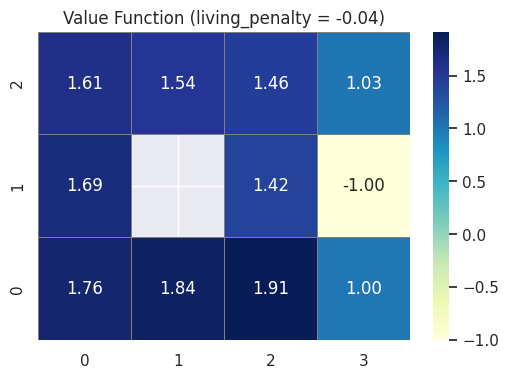


Policy (living_penalty = -0.04):
>  >  >  G
^  W  ^  P
^  <  <  <


In [ ]:

rewards = make_rewards(DEFAULT_LIVING_PENALTY)
V_default = value_iteration(STATES, rewards, gamma=GAMMA, theta=1e-4)
policy_default = extract_policy(STATES, V_default, rewards, gamma=GAMMA)


plot_value_heatmap(V_default, title="Value Function (living_penalty = -0.04)")
print_policy(policy_default, title="Policy (living_penalty = -0.04)")


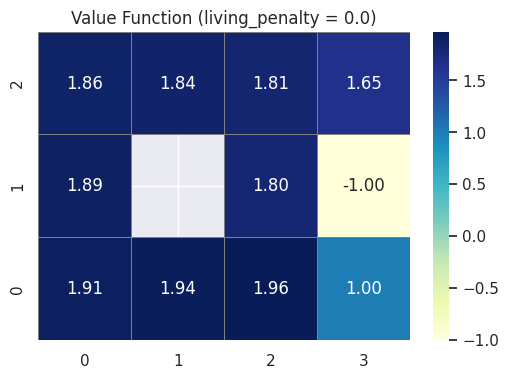


Policy (living_penalty = 0.0):
>  >  >  G
^  W  <  P
^  <  <  v


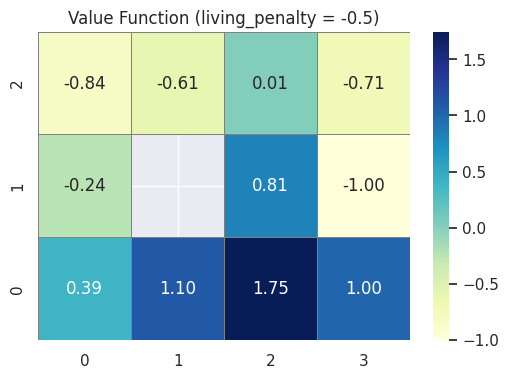


Policy (living_penalty = -0.5):
>  >  >  G
^  W  ^  P
^  >  ^  <


In [ ]:
# 1) living penalty = 0.0
rewards_zero = make_rewards(0.0)
V_zero = value_iteration(STATES, rewards_zero, gamma=GAMMA, theta=1e-4)
policy_zero = extract_policy(STATES, V_zero, rewards_zero, gamma=GAMMA)
plot_value_heatmap(V_zero, title="Value Function (living_penalty = 0.0)")
print_policy(policy_zero, title="Policy (living_penalty = 0.0)")

# 2) living penalty = -0.5 (higher penalty magnitude)
rewards_high = make_rewards(-0.5)
V_high = value_iteration(STATES, rewards_high, gamma=GAMMA, theta=1e-4)
policy_high = extract_policy(STATES, V_high, rewards_high, gamma=GAMMA)
plot_value_heatmap(V_high, title="Value Function (living_penalty = -0.5)")
print_policy(policy_high, title="Policy (living_penalty = -0.5)")
